In [14]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from arch import arch_model

import matplotlib.pyplot as plt
from scipy import stats

In [27]:
import json
x = '[1, 2, 3, 4, 5]'
json.loads(x)

[1, 2, 3, 4, 5]

In [15]:
PRICE_FILES = ["data/Stocks/AlternativeEnergy_Price.csv", "data/Stocks/Automobile_Price.csv", "data/Stocks/Bank_Price.csv",
                        "data/Stocks/Beverage_Price.csv", "data/Stocks/BioTech_Price.csv", "data/Stocks/Chemical_Price.csv",
                        "data/Stocks/Construction_Price.csv", "data/Stocks/Electricity_Price.csv", "data/Stocks/Electronic_Price.csv",
                        "data/Stocks/Finance_Price.csv", "data/Stocks/Fix_Price.csv", "data/Stocks/Food_Price.csv", 
                        "data/Stocks/FoodProducer_Price.csv", "data/Stocks/Gas_Price.csv", "data/Stocks/GeneralIndustrial_Price.csv",
                        "data/Stocks/GeneralRetail_Price.csv", "data/Stocks/Hardware_Price.csv", "data/Stocks/Health_Price.csv",
                        "data/Stocks/Household_Price.csv", "data/Stocks/IndustrialEngineer_Price.csv", "data/Stocks/IndustrialMetal_Price.csv", 
                        "data/Stocks/IndustrialTransport_Price.csv", "data/Stocks/Insurance_Price.csv", "data/Stocks/Leisure_Price.csv",
                        "data/Stocks/Media_Price.csv", "data/Stocks/Mining_Price.csv", "data/Stocks/NonLifeInsure_Price.csv",
                        "data/Stocks/OilProducer_Price.csv", "data/Stocks/Paper_Price.csv", "data/Stocks/PersonalGoods_Price.csv",
                        "data/Stocks/RealEstate_Price.csv", "data/Stocks/Software_Price.csv", "data/Stocks/Support_Price.csv",
                        "data/Stocks/Travel_Price.csv", "data/Stocks/Unclassified_Price.csv"]

VOLUME_FILES = ["data/Stocks/AlternativeEnergy_Volume.csv", "data/Stocks/Automobile_Volume.csv", "data/Stocks/Automobile_Volume.csv",
                           "data/Stocks/Beverage_Volume.csv", "data/Stocks/BioTech_Volume.csv", "data/Stocks/Chemical_Volume.csv",
                           "data/Stocks/Construction_Volume.csv", "data/Stocks/Electricity_Volume.csv", "data/Stocks/Electronic_Volume.csv",
                           "data/Stocks/Finance_Volume.csv", "data/Stocks/Fix_Volume.csv", "data/Stocks/Food_Volume.csv", 
                           "data/Stocks/FoodProducer_Volume.csv", "data/Stocks/Gas_Volume.csv", "data/Stocks/GeneralIndustrial_Volume.csv",
                           "data/Stocks/GeneralRetail_Volume.csv", "data/Stocks/Hardware_Volume.csv", "data/Stocks/Health_Volume.csv", 
                           "data/Stocks/Household_Volume.csv", "data/Stocks/IndustrialEngineer_Volume.csv", "data/Stocks/IndustrialMetal_Volume.csv", 
                           "data/Stocks/IndustrialTransport_Volume.csv", "data/Stocks/Insurance_Volume.csv", "data/Stocks/Leisure_Volume.csv",
                           "data/Stocks/Media_Volume.csv", "data/Stocks/Mining_Volume.csv", "data/Stocks/NonLifeInsure_Volume.csv",
                           "data/Stocks/OilProducer_Volume.csv", "data/Stocks/Paper_Volume.csv", "data/Stocks/PersonalGoods_Volume.csv",
                           "data/Stocks/RealEstate_Volume.csv", "data/Stocks/Software_Volume.csv", "data/Stocks/Support_Volume.csv",
                           "data/Stocks/Travel_Volume.csv", "data/Stocks/Unclassified_Volume.csv"]

In [16]:
def RenameHeader(col_name, col_type):
    if col_name == "Code":
        return "Code"
    else:
        if col_type == "Price":
            return col_name[2:-3]
        else:
            return col_name[2:-4]

In [17]:
# Edit 4: Helper Functions
def Mean(List):
    return sum(List)/len(List)

def Median(List):
    return np.percentile(List, 50)

def Min(List):
    return min(List)

def Max(List):
    return max(List)

def Find_25(List):
    return np.percentile(List, 25)

def Find_75(List):
    return np.percentile(List, 75)


In [18]:
def Clean(price, volume):
    
    """
    Argument: price dataframe and volume dataframe
    Return: return the tuples of price dataframes (2014-2019) and volume dataframes (2014-2019)
                where each one of them is filtered out missing col, missing price from prev year, missing vol from prev year,
                        no volume traded occurs from prev year
    Note: this function requires RenameHeader (Defined above) and pandas
    """
    
    # Read two dataframes and filter to have files from 2014 to 2019
    price_df = pd.read_csv(price).rename(columns = lambda x: RenameHeader(x, "Price"))
    price_df['Code'] = pd.to_datetime(price_df['Code'])
    price_df = price_df[(price_df['Code'] > '2014-01-01') & (price_df['Code'] < '2020-01-01')]
    
    vol_df = pd.read_csv(volume).rename(columns = lambda x: RenameHeader(x, "Vol"))
    vol_df['Code'] = pd.to_datetime(vol_df['Code'])
    vol_df = vol_df[(vol_df['Code'] > '2014-01-01') & (vol_df['Code'] < '2020-01-01')]
    
    # Use only common cols in two dataframes
    common_cols = price_df.columns.intersection(vol_df.columns).tolist()
    price_df = price_df[common_cols]
    vol_df = vol_df[common_cols]
    
    # Temporarily include SET_VOL to filter holidays
    SET_IDX_VOL = pd.read_csv('data/SET/SET_VO.csv', parse_dates = True)
    SET_IDX_VOL = SET_IDX_VOL.rename(columns = {'Code': 'Code', 'BNGKSET(VO)': 'Volume'})
    SET_IDX_VOL['Code'] = pd.to_datetime(SET_IDX_VOL['Code'])
    
    # Filter holiday on price dataframes
    price_df = pd.merge(price_df, SET_IDX_VOL, how = 'inner', on = 'Code')
    price_df = price_df[price_df['Volume'].notna()]
    price_df.drop(['Volume'], axis = 1, inplace = True)
    
    # Filter holiday on price dataframes
    vol_df = pd.merge(vol_df, SET_IDX_VOL, how = 'inner', on = 'Code')
    vol_df = vol_df[vol_df['Volume'].notna()]
    vol_df.drop(['Volume'], axis = 1, inplace = True)
    
    # Create two dataframes
    price_df_s = []
    vol_df_s = []
    price_df_s.append(price_df[(price_df['Code'] > '2014-01-01') & (price_df['Code'] < '2015-01-01')])
    vol_df_s.append(vol_df[(vol_df['Code'] > '2014-01-01') & (vol_df['Code'] < '2015-01-01')])
    price_df_s.append(price_df[(price_df['Code'] > '2015-01-01') & (price_df['Code'] < '2020-01-01')])
    vol_df_s.append(vol_df[(vol_df['Code'] > '2015-01-01') & (vol_df['Code'] < '2020-01-01')])    
    
        
    # Filter the columns by
    # 1) Any missing + zero volume from previous year
    for i in range(1):
        
        price_filter_df = price_df_s[i+1]
        vol_filter_df = vol_df_s[i+1]
        
        price_null = price_filter_df.columns[price_filter_df.isna().any()].tolist()
        vol_null = vol_filter_df.columns[vol_filter_df.isna().any()].tolist()
        # Create another copy (a bit inefficient, but it works)
        vol_temp = vol_filter_df.drop(['Code'], axis = 1, inplace = False)
        vol_gt_zero = vol_temp.columns[(vol_temp <= 0).any()].tolist()
        
        filtered_out_col = list(set().union(price_null,vol_null,vol_gt_zero))
        
        price_df_s[i+1].drop(filtered_out_col, axis = 1, inplace = True)
        vol_df_s[i+1].drop(filtered_out_col, axis = 1, inplace = True)
        
        
    return (price_df_s, vol_df_s)

In [19]:
def GenerateFeatures(price_list, vol_list):
    """
    Input: price dataframes list, vol dataframes list
    Return: list of list of dict
    (for example, [automobile, ...] -> [2014, 2015, 2016, ...] -> {price: price_df, vol: vol_df, feature1: ...})
    """
    return_list = []
    for i in range(len(price_list)):
        compile_list = []
        price_df_s, vol_df_s = Clean(price_list[i], vol_list[i])
        
        for j in range(len(price_df_s)):
            sub_dict = {}
            price_df = price_df_s[j]
            vol_df = vol_df_s[j]
            
            ## Define new dataframes: return dataframe
            return1_df = pd.DataFrame(index=price_df.index, columns=price_df.columns)
            return1_df['Code'] = price_df['Code']
            
            return3_df = pd.DataFrame(index=price_df.index, columns=price_df.columns)
            return3_df['Code'] = price_df['Code']
            
            return5_df = pd.DataFrame(index=price_df.index, columns=price_df.columns)
            return5_df['Code'] = price_df['Code']    
            
            return10_df = pd.DataFrame(index=price_df.index, columns=price_df.columns)
            return10_df['Code'] = price_df['Code']
            
            return14_df = pd.DataFrame(index=price_df.index, columns=price_df.columns)
            return14_df['Code'] = price_df['Code']
            
            return20_df = pd.DataFrame(index=price_df.index, columns=price_df.columns)
            return20_df['Code'] = price_df['Code']
            
            for col in list(price_df.columns):
                if col != 'Code':
                    # Calculate log return here
                    return1_df[col] = 100*(np.log(price_df.loc[:, col]) - np.log(price_df.loc[:, col].shift(1)))
                    return3_df[col] = 100*(np.log(price_df.loc[:, col]) - np.log(price_df.loc[:, col].shift(3)))
                    return5_df[col] = 100*(np.log(price_df.loc[:, col]) - np.log(price_df.loc[:, col].shift(5)))
                    return10_df[col] = 100*(np.log(price_df.loc[:, col]) - np.log(price_df.loc[:, col].shift(10)))
                    return14_df[col] = 100*(np.log(price_df.loc[:, col]) - np.log(price_df.loc[:, col].shift(14)))
                    return20_df[col] = 100*(np.log(price_df.loc[:, col]) - np.log(price_df.loc[:, col].shift(20)))
                    
                    #return3_df[col] = 100*price_df.loc[:, col].pct_change(periods = 3)
                    #return5_df[col] = 100*price_df.loc[:, col].pct_change(periods = 5)
                    #return10_df[col] = 100*price_df.loc[:, col].pct_change(periods = 10)
                    #return14_df[col] = 100*price_df.loc[:, col].pct_change(periods = 14)
                    #return20_df[col] = 100*price_df.loc[:, col].pct_change(periods = 20)
                    
            
            sub_dict['price'] = price_df
            sub_dict['vol'] = vol_df
            sub_dict['ret_1'] = return1_df
            sub_dict['ret_3'] = return3_df
            sub_dict['ret_5'] = return5_df     
            sub_dict['ret_10'] = return10_df
            sub_dict['ret_14'] = return14_df
            sub_dict['ret_20'] = return20_df

            compile_list.append(sub_dict)
            
        return_list.append(compile_list)
        
    return return_list

In [20]:
def Rearrange(sector_list):
    """
    Input: sector_list (return list from GenerateFeatures function above)
    Return: list of list of dict as follows
        [2014, 2015, 2016, ...] -> {key: PTT, data: dataframes}
        (similar how we usually render in React)
    """
    # Each sublist is for each year
    return_list = [[], []]
    
    # i runs from 0 to # of sectors - 1
    for i in range(len(sector_list)):
        sector_stocks = sector_list[i]
        # j runs from 0 to 5 (0 -> 2014, 5 -> 2019)
        for j in range(2):
            sector_year_dict = sector_stocks[j]
            col_names = sector_year_dict['price'].columns.tolist()
            # k runs for each column except "Code"
            for k in range(1, len(col_names)):
                stock_name = col_names[k]
                # Step 1: create blank dataframes
                new_data = pd.DataFrame(index=sector_year_dict['price'].index, columns= ['Code', 'vol', 'price', 'ret_3', 'ret_5', 'ret_10', 'ret_14', 'ret_20'])
                new_data['Code'] = sector_year_dict['price']['Code']
                # Step 2: Retrieve data from the key and insert it into new_data
                new_data['vol'] = sector_year_dict['vol'].loc[:, stock_name]
                new_data['price'] = sector_year_dict['price'].loc[:, stock_name]
                new_data['ret_1'] = sector_year_dict['ret_1'].loc[:, stock_name]
                new_data['ret_3'] = sector_year_dict['ret_3'].loc[:, stock_name]
                new_data['ret_5'] = sector_year_dict['ret_5'].loc[:, stock_name]
                new_data['ret_10'] = sector_year_dict['ret_10'].loc[:, stock_name]
                new_data['ret_14'] = sector_year_dict['ret_14'].loc[:, stock_name]
                new_data['ret_20'] = sector_year_dict['ret_20'].loc[:, stock_name]
                
                # Step 3: Drop rows with at least one missing value
                new_data.dropna(axis = 0, how = 'any', inplace = True)
                # Step 4: Insert the new_dataframe into appropriate place (notice we use dict for convenience later)
                new_dict = {'key': stock_name, 'data': new_data}
                return_list[j].append(new_dict)
                
    return return_list

In [21]:
def GetVolumeTraded(RenderList):
    """
    input: RenderList, using the same data structure corresponding to Rearrange function (defined above)
    Process: Add key of volume_traded in each stock-year (calculated from last year)
    Return: nothing
    """
    # For each year from 2015 to 2019
    for i in range(1, 2):
        
        # For each stock that we want to add the new key: volume traded
        for stock in RenderList[i]:
            stock['volume_traded'] = stock['data'].loc[:, 'vol'].mean()
            

In [22]:
def RemoveNoKey(RenderList, key):
    remove_keys = []
    
    for entry in RenderList:
        if key not in entry:
            remove_keys.append(entry["key"]) # Append stock abbreviations we want to remove
            
    if len(remove_keys) == 0:
        return RenderList
    else:
        return [x for x in RenderList if x["key"] not in remove_keys]

In [23]:
def RemoveInsigLM(RenderList):
    """
    Input: RenderList, using the same data structure corresponding to Rearrange function
    This will filter only stocks where LM test is rejected: there is an ARCH effect
    Return: nothing
    """
    columns = ['Number_of_Firms', 'Sig_LM_5%', 'log_ret']
    return1_df = pd.DataFrame(index=range(10) , columns= columns)
    return1_df = return1_df.fillna(0)
    
    return3_df = pd.DataFrame(index=range(10) , columns= columns)
    return3_df = return3_df.fillna(0)
    
    return5_df = pd.DataFrame(index=range(10) , columns= columns)
    return5_df = return5_df.fillna(0)
    
    return10_df = pd.DataFrame(index=range(10) , columns= columns)
    return10_df = return10_df.fillna(0)
    
    return14_df = pd.DataFrame(index=range(10) , columns= columns)
    return14_df = return14_df.fillna(0)
    
    return20_df = pd.DataFrame(index=range(10) , columns= columns)
    return20_df = return20_df.fillna(0)
    
    for i in range(1, 2):
        # For each year, split stocks into ten deciles based on previous volume traded
        stock_list = RemoveNoKey(RenderList[i], 'volume_traded')
        stock_list = sorted(stock_list, key = lambda x: x['volume_traded'])
        ten_splits = np.array_split(stock_list, 10)
        
        for j in range(10):
            
            # Record the number of firms 
            return1_df.loc[j, 'Number_of_Firms'] += len(ten_splits[j])
            return3_df.loc[j, 'Number_of_Firms'] += len(ten_splits[j])
            return5_df.loc[j, 'Number_of_Firms'] += len(ten_splits[j])
            return10_df.loc[j, 'Number_of_Firms'] += len(ten_splits[j])
            return14_df.loc[j, 'Number_of_Firms'] += len(ten_splits[j])
            return20_df.loc[j, 'Number_of_Firms'] += len(ten_splits[j])
            
            # Accumulator
            significant_LM_1,  significant_LM_3, significant_LM_5, significant_LM_10, significant_LM_14, significant_LM_20 = 0, 0, 0, 0, 0, 0
            returns = [0, 0, 0, 0, 0, 0]
            
            for Render in ten_splits[j]:
                
                stock_df = Render['data']
                
                returns[0] += stock_df['ret_1'].mean()
                returns[1] += stock_df['ret_3'].mean()
                returns[2] += stock_df['ret_5'].mean()
                returns[3] += stock_df['ret_10'].mean()
                returns[4] += stock_df['ret_14'].mean()
                returns[5] += stock_df['ret_20'].mean()
                
                # Check for significance
                if (sm.stats.diagnostic.het_arch(stock_df['ret_1']))[1] <= 0.05:
                    significant_LM_1 += 1
                    Render['LM_sig_1'] = True
                
                if (sm.stats.diagnostic.het_arch(stock_df['ret_3']))[1] <= 0.05:
                    significant_LM_3 += 1
                    Render['LM_sig_3'] = True
                    
                if (sm.stats.diagnostic.het_arch(stock_df['ret_5']))[1] <= 0.05:
                    significant_LM_5 += 1
                    Render['LM_sig_5'] = True
                    
                if (sm.stats.diagnostic.het_arch(stock_df['ret_10']))[1] <= 0.05:
                    significant_LM_10 += 1
                    Render['LM_sig_10'] = True
                    
                if (sm.stats.diagnostic.het_arch(stock_df['ret_14']))[1] <= 0.05:
                    significant_LM_14 += 1
                    Render['LM_sig_14'] = True
                    
                if (sm.stats.diagnostic.het_arch(stock_df['ret_20']))[1] <= 0.05:
                    significant_LM_20 += 1
                    Render['LM_sig_20'] = True
                    
            return1_df.loc[j,  'Sig_LM_5%'] += significant_LM_1
            return3_df.loc[j,  'Sig_LM_5%'] += significant_LM_3
            return5_df.loc[j,  'Sig_LM_5%'] += significant_LM_5
            return10_df.loc[j,  'Sig_LM_5%'] += significant_LM_10        
            return14_df.loc[j,  'Sig_LM_5%'] += significant_LM_14
            return20_df.loc[j,  'Sig_LM_5%'] += significant_LM_20   
            
            return1_df.loc[j,  'log_ret'] += returns[0]/len(ten_splits[j])
            return3_df.loc[j,  'log_ret'] += returns[1]/len(ten_splits[j])
            return5_df.loc[j,  'log_ret'] += returns[2]/len(ten_splits[j])
            return10_df.loc[j,  'log_ret'] += returns[3]/len(ten_splits[j])    
            return14_df.loc[j, 'log_ret'] += returns[4]/len(ten_splits[j])
            return20_df.loc[j, 'log_ret'] += returns[5]/len(ten_splits[j])             

    # Get average value
    return1_df.to_csv('ARCH_Test_Pool_1.csv')
    return3_df.to_csv('ARCH_Test_Pool_3.csv')
    return5_df.to_csv('ARCH_Test_Pool_5.csv')
    return10_df.to_csv('ARCH_Test_Pool_10.csv')
    return14_df.to_csv('ARCH_Test_Pool_14.csv')
    return20_df.to_csv('ARCH_Test_Pool_20.csv')

In [31]:
def GenerateTable_GARCH(RenderList):
    """
    Input: RenderList, using the same data structure corresponding to Rearrange function and has the key volume_traded
    This will output the result of average coefficient across five years into csv file
    Return: nothing
    """
    # This is the return dataframe with three columns corresponding to each coefficient
    
   # Edit 1: Enable to record mean, min, 25%, median, 75%, max
    temp_col = ['GARCH_alpha',  'GARCH_beta', 'GJR_alpha', 'GJR_beta', 'GJR_gamma']
    columns = temp_col
    #for var in temp_col:
    #    columns.append((var + '_mean'))
    #    columns.append((var + '_min'))
    #    columns.append((var + '_25'))
     #   columns.append((var + '_median'))
     #   columns.append((var + '_75'))
    #    columns.append((var + '_max'))
    
    return1_df = pd.DataFrame(index=range(10) , columns= columns)
    return1_df = return1_df.fillna(0)    
    
    return3_df = pd.DataFrame(index=range(10) , columns= columns)
    return3_df = return3_df.fillna(0)
    
    return5_df = pd.DataFrame(index=range(10) , columns= columns)
    return5_df = return5_df.fillna(0)
    
    return10_df = pd.DataFrame(index=range(10) , columns= columns)
    return10_df = return10_df.fillna(0)
    
    return14_df = pd.DataFrame(index=range(10) , columns= columns)
    return14_df = return14_df.fillna(0)
    
    return20_df = pd.DataFrame(index=range(10) , columns= columns)
    return20_df = return20_df.fillna(0)
    
    for i in range(1, 2):
        # Sort by volume traded and split into ten sub-lists
        
        stock_list_1 = RemoveNoKey(RenderList[i], 'LM_sig_1')
        stock_list_1 = sorted(stock_list_1, key = lambda x: x['volume_traded'])
        ten_splits_1 = np.array_split(stock_list_1, 10)
        
        stock_list_3 = RemoveNoKey(RenderList[i], 'LM_sig_3')
        stock_list_3 = sorted(stock_list_3, key = lambda x: x['volume_traded'])
        ten_splits_3 = np.array_split(stock_list_3, 10)
        
        stock_list_5 = RemoveNoKey(RenderList[i], 'LM_sig_5')    
        stock_list_5 = sorted(stock_list_5, key = lambda x: x['volume_traded'])
        ten_splits_5 = np.array_split(stock_list_5, 10)
        
        stock_list_10 = RemoveNoKey(RenderList[i], 'LM_sig_10')
        stock_list_10 = sorted(stock_list_10, key = lambda x: x['volume_traded'])
        ten_splits_10 = np.array_split(stock_list_10, 10)
        
        stock_list_14 = RemoveNoKey(RenderList[i], 'LM_sig_14')
        stock_list_14 = sorted(stock_list_14, key = lambda x: x['volume_traded'])
        ten_splits_14 = np.array_split(stock_list_14, 10)
        
        stock_list_20 = RemoveNoKey(RenderList[i], 'LM_sig_20')
        stock_list_20 = sorted(stock_list_20, key = lambda x: x['volume_traded'])
        ten_splits_20 = np.array_split(stock_list_20, 10)
        
        for j in range(10):
            
            # Edit 2: Accumulator: record each coeff in each sub-list
            ret1_coeffs = [[] for x in range(5)]
            ret3_coeffs = [[] for x in range(5)]
            ret5_coeffs = [[] for x in range(5)]
            ret10_coeffs = [[] for x in range(5)]
            ret14_coeffs = [[] for x in range(5)]
            ret20_coeffs = [[] for x in range(5)]
            
            for Render in ten_splits_1[j]:
                
                stock_df = Render['data']
                
                GARCH = arch_model(stock_df['ret_1'], p=1, q=1).fit(update_freq=5, disp = 'off')
                GJR_GARCH = arch_model(stock_df['ret_1'], p=1, o = 1, q=1).fit(update_freq=5, disp = 'off')
                
                # Edit 3: Append each coeff in the assigned sub-list
                ret1_coeffs[0].append(GARCH.params['alpha[1]'])
                ret1_coeffs[1].append(GARCH.params['beta[1]'])
                ret1_coeffs[2].append(GJR_GARCH.params['alpha[1]'])
                ret1_coeffs[3].append(GJR_GARCH.params['beta[1]'])
                ret1_coeffs[4].append(GJR_GARCH.params['gamma[1]'])
                
            for k in range(len(temp_col)):
                # temp_col[0] = 'GARCH_alpha'
                # ret1_coeffs[0] = the list containing each coeff
                
                return1_df.loc[j, temp_col[k]] = str(ret1_coeffs[k])
                
                #return1_df.loc[j, temp_col[k]+'_min'] = Min(ret1_coeffs[k])
                #return1_df.loc[j, temp_col[k]+'_25'] = Find_25(ret1_coeffs[k])
               # return1_df.loc[j, temp_col[k]+'_median'] = Median(ret1_coeffs[k])
                #return1_df.loc[j, temp_col[k]+'_75'] = Find_75(ret1_coeffs[k])
                #return1_df.loc[j, temp_col[k]+'_max'] = Max(ret1_coeffs[k])
            
            
            for Render in ten_splits_3[j]:
                
                stock_df = Render['data']
                
                GARCH = arch_model(stock_df['ret_3'], p=1, q=1).fit(update_freq=5, disp = 'off')
                GJR_GARCH = arch_model(stock_df['ret_3'], p=1, o = 1, q=1).fit(update_freq=5, disp = 'off')
                
                ret3_coeffs[0].append(GARCH.params['alpha[1]'])
                ret3_coeffs[1].append(GARCH.params['beta[1]'])
                ret3_coeffs[2].append(GJR_GARCH.params['alpha[1]'])
                ret3_coeffs[3].append(GJR_GARCH.params['beta[1]'])
                ret3_coeffs[4].append(GJR_GARCH.params['gamma[1]'])
                
            for k in range(len(temp_col)):
                # temp_col[0] = 'GARCH_alpha'
                # ret1_coeffs[0] = the list containing each coeff
                return3_df.loc[j, temp_col[k]] = str(ret3_coeffs[k])
                #return3_df.loc[j, temp_col[k]+'_mean'] = Mean(ret3_coeffs[k])
                #return3_df.loc[j, temp_col[k]+'_min'] = Min(ret3_coeffs[k])
                #return3_df.loc[j, temp_col[k]+'_25'] = Find_25(ret3_coeffs[k])
                #return3_df.loc[j, temp_col[k]+'_median'] = Median(ret3_coeffs[k])
                #return3_df.loc[j, temp_col[k]+'_75'] = Find_75(ret3_coeffs[k])
                #return3_df.loc[j, temp_col[k]+'_max'] = Max(ret3_coeffs[k])     

            for Render in ten_splits_5[j]:
                
                stock_df = Render['data']
                
                GARCH = arch_model(stock_df['ret_5'], p=1, q=1).fit(update_freq=5, disp = 'off')
                GJR_GARCH = arch_model(stock_df['ret_5'], p=1, o = 1, q=1).fit(update_freq=5, disp = 'off')
                
                ret5_coeffs[0].append(GARCH.params['alpha[1]'])
                ret5_coeffs[1].append(GARCH.params['beta[1]'])
                ret5_coeffs[2].append(GJR_GARCH.params['alpha[1]'])
                ret5_coeffs[3].append(GJR_GARCH.params['beta[1]'])
                ret5_coeffs[4].append(GJR_GARCH.params['gamma[1]'])
                
            for k in range(len(temp_col)):
                # temp_col[0] = 'GARCH_alpha'
                # ret1_coeffs[0] = the list containing each coeff
                return5_df.loc[j, temp_col[k]] = str(ret5_coeffs[k])
                #return5_df.loc[j, temp_col[k]+'_mean'] = Mean(ret5_coeffs[k])
                #return5_df.loc[j, temp_col[k]+'_min'] = Min(ret5_coeffs[k])
                #return5_df.loc[j, temp_col[k]+'_25'] = Find_25(ret5_coeffs[k])
                #return5_df.loc[j, temp_col[k]+'_median'] = Median(ret5_coeffs[k])
                #return5_df.loc[j, temp_col[k]+'_75'] = Find_75(ret5_coeffs[k])
                #return5_df.loc[j, temp_col[k]+'_max'] = Max(ret5_coeffs[k])                  
            
            for Render in ten_splits_10[j]:
                
                stock_df = Render['data']
                
                GARCH = arch_model(stock_df['ret_10'], p=1, q=1).fit(update_freq=5, disp = 'off')
                GJR_GARCH = arch_model(stock_df['ret_10'], p=1, o = 1, q=1).fit(update_freq=5, disp = 'off')
                
                ret10_coeffs[0].append(GARCH.params['alpha[1]'])
                ret10_coeffs[1].append(GARCH.params['beta[1]'])
                ret10_coeffs[2].append(GJR_GARCH.params['alpha[1]'])
                ret10_coeffs[3].append(GJR_GARCH.params['beta[1]'])
                ret10_coeffs[4].append(GJR_GARCH.params['gamma[1]'])
                
            for k in range(len(temp_col)):
                # temp_col[0] = 'GARCH_alpha'
                # ret1_coeffs[0] = the list containing each coeff
                return10_df.loc[j, temp_col[k]] = str(ret10_coeffs[k])
                #return10_df.loc[j, temp_col[k]+'_mean'] = Mean(ret10_coeffs[k])
                #return10_df.loc[j, temp_col[k]+'_min'] = Min(ret10_coeffs[k])
                #return10_df.loc[j, temp_col[k]+'_25'] = Find_25(ret10_coeffs[k])
                #return10_df.loc[j, temp_col[k]+'_median'] = Median(ret10_coeffs[k])
                #return10_df.loc[j, temp_col[k]+'_75'] = Find_75(ret10_coeffs[k])
                #return10_df.loc[j, temp_col[k]+'_max'] = Max(ret10_coeffs[k])         
            
            for Render in ten_splits_14[j]:
                
                stock_df = Render['data']
                
                GARCH = arch_model(stock_df['ret_14'], p=1, q=1).fit(update_freq=5, disp = 'off')
                GJR_GARCH = arch_model(stock_df['ret_14'], p=1, o = 1, q=1).fit(update_freq=5, disp = 'off')
                
                ret14_coeffs[0].append(GARCH.params['alpha[1]'])
                ret14_coeffs[1].append(GARCH.params['beta[1]'])
                ret14_coeffs[2].append(GJR_GARCH.params['alpha[1]'])
                ret14_coeffs[3].append(GJR_GARCH.params['beta[1]'])
                ret14_coeffs[4].append(GJR_GARCH.params['gamma[1]'])
                
            for k in range(len(temp_col)):
                # temp_col[0] = 'GARCH_alpha'
                # ret1_coeffs[0] = the list containing each coeff
                return14_df.loc[j, temp_col[k]] = str(ret14_coeffs[k])
                #return14_df.loc[j, temp_col[k]+'_mean'] = Mean(ret14_coeffs[k])
                #return14_df.loc[j, temp_col[k]+'_min'] = Min(ret14_coeffs[k])
                #return14_df.loc[j, temp_col[k]+'_25'] = Find_25(ret14_coeffs[k])
                #return14_df.loc[j, temp_col[k]+'_median'] = Median(ret14_coeffs[k])
                #return14_df.loc[j, temp_col[k]+'_75'] = Find_75(ret14_coeffs[k])
                #return14_df.loc[j, temp_col[k]+'_max'] = Max(ret14_coeffs[k])   
            
            for Render in ten_splits_20[j]:
                
                stock_df = Render['data']
                
                GARCH = arch_model(stock_df['ret_20'], p=1, q=1).fit(update_freq=5, disp = 'off')
                GJR_GARCH = arch_model(stock_df['ret_20'], p=1, o = 1, q=1).fit(update_freq=5, disp = 'off')
                
                ret20_coeffs[0].append(GARCH.params['alpha[1]'])
                ret20_coeffs[1].append(GARCH.params['beta[1]'])
                ret20_coeffs[2].append(GJR_GARCH.params['alpha[1]'])
                ret20_coeffs[3].append(GJR_GARCH.params['beta[1]'])
                ret20_coeffs[4].append(GJR_GARCH.params['gamma[1]'])
                
            for k in range(len(temp_col)):
                # temp_col[0] = 'GARCH_alpha'
                # ret1_coeffs[0] = the list containing each coeff
                return20_df.loc[j, temp_col[k]] = str(ret20_coeffs[k])
                #return20_df.loc[j, temp_col[k]+'_mean'] = Mean(ret20_coeffs[k])
                #return20_df.loc[j, temp_col[k]+'_min'] = Min(ret20_coeffs[k])
                #return20_df.loc[j, temp_col[k]+'_25'] = Find_25(ret20_coeffs[k])
                #return20_df.loc[j, temp_col[k]+'_median'] = Median(ret20_coeffs[k])
                #return20_df.loc[j, temp_col[k]+'_75'] = Find_75(ret20_coeffs[k])
                #return20_df.loc[j, temp_col[k]+'_max'] = Max(ret20_coeffs[k])           
            
    # Get average value
    return1_df.to_csv('Full_Model_1_raw.csv')
    return3_df.to_csv('Full_Model_3_raw.csv') 
    return5_df.to_csv('Full_Model_5_raw.csv')
    return10_df.to_csv('Full_Model_10_raw.csv')
    return14_df.to_csv('Full_Model_14_raw.csv')
    return20_df.to_csv('Full_Model_20_raw.csv')
    

    

In [32]:
cleaned_dfs = GenerateFeatures(PRICE_FILES, VOLUME_FILES)
RenderList = Rearrange(cleaned_dfs)
GetVolumeTraded(RenderList)
RemoveInsigLM(RenderList)
GenerateTable_GARCH(RenderList)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\User\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:625: FutureWarning: The default value of nlags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setmaxlags or period to silence this warning.
  FutureWarning)


In [13]:
Volumes = [x['volume_traded'] for x in RenderList[1]]

(array([186.,  21.,   9.,   2.,   4.,   3.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([4.67609675e+01, 1.25907897e+04, 2.51348185e+04, 3.76788473e+04,
        5.02228760e+04, 6.27669048e+04, 7.53109335e+04, 8.78549623e+04,
        1.00398991e+05, 1.12943020e+05, 1.25487049e+05, 1.38031077e+05,
        1.50575106e+05, 1.63119135e+05, 1.75663164e+05, 1.88207192e+05,
        2.00751221e+05, 2.13295250e+05, 2.25839279e+05, 2.38383307e+05,
        2.50927336e+05]),
 <a list of 20 Patch objects>)

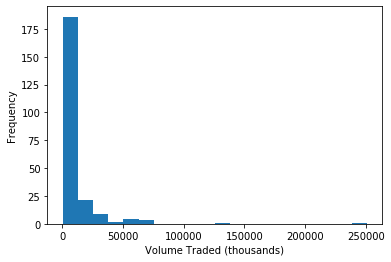

In [15]:
import matplotlib.pyplot as plt
n_bins = 20

fig, ax = plt.subplots()
plt.xlabel('Volume Traded (thousands)')
plt.ylabel('Frequency')
ax.hist(Volumes, bins=n_bins)